In [19]:
%pip install --upgrade pip

In [20]:
%pip install fiftyone wandb open-clip-torch

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np
import os
import wandb
import fiftyone as fo
import fiftyone.brain as fob
import open_clip

if not os.path.exists("utils/__init__.py"):
    open("utils/__init__.py", "a").close()

from utils import UNet_utils, ddpm_utils

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Specific Data Mapping
id_to_name = {
    0: "daisy",
    2: "roses",
    3: "sunflower"
}
target_ids = [0, 2, 3]

n_T = 400
n_feat = 128
n_classes = 10
img_size = 32

Using device: cuda


In [22]:
# 1. Initialize U-Net
print("Initializing Model...")
model = UNet_utils.UNet(
    T=n_T,
    img_ch=3,
    img_size=img_size,
    c_embed_dim=n_classes
)
model.to(device)
model.eval()

# 2. Initialize Diffusion Wrapper
betas = torch.linspace(1e-4, 0.02, n_T).to(device)
ddpm = ddpm_utils.DDPM(B=betas, device=device)

# 3. Register Hook
inter_embeddings = {}
def get_activation(name):
    def hook(model, input, output):
        inter_embeddings[name] = output.detach()
    return hook

model.down2.register_forward_hook(get_activation('down2'))
print("Model ready and Hook registered on 'down2'.")

Initializing Model...
Model ready and Hook registered on 'down2'.


In [23]:
import shutil
import os

checkpoint_path = "real_data/.ipynb_checkpoints"
if os.path.exists(checkpoint_path):
    shutil.rmtree(checkpoint_path)
    print(f"Deleted hidden folder: {checkpoint_path}")
else:
    print("No hidden checkpoint folder found (it might be gone already).")

print("Folders in real_data:", os.listdir("real_data"))

No hidden checkpoint folder found (it might be gone already).
Folders in real_data: ['daisy', 'roses', 'sunflower']


In [24]:
print("Loading Real Data...")
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

real_dataset = ImageFolder(root='real_data', transform=transform)

valid_indices = []
folder_name_to_id = {v: k for k, v in id_to_name.items()}

for i, (path, target_idx) in enumerate(real_dataset.samples):
    folder_class = real_dataset.classes[target_idx]

    if folder_class in folder_name_to_id:
        valid_indices.append(i)

subset_dataset = torch.utils.data.Subset(real_dataset, valid_indices)
real_loader = DataLoader(subset_dataset, batch_size=32, shuffle=False)

print(f"Loaded {len(subset_dataset)} real images.")

Loading Real Data...
Loaded 1166 real images.


In [25]:

def generate_batch(class_label, num_images):
    c_indices = torch.tensor([class_label] * num_images).to(device)
    c_onehot = F.one_hot(c_indices.to(torch.int64), num_classes=n_classes).float()

    with torch.no_grad():
        x_gen, _ = ddpm_utils.sample_w(
            model, ddpm, (3, img_size, img_size), n_T, c_onehot, device, w_tests=[2.0]
        )
    return x_gen, inter_embeddings['down2']

# Generation Loop
print("Generating AI Counterparts...")
ai_images_list = []
ai_embeddings_list = []


n_per_class = max(len(subset_dataset) // 3, 4)

for cid in target_ids:
    print(f"   -> Generating {n_per_class} images for {id_to_name[cid]}...")
    imgs, embs = generate_batch(cid, n_per_class)
    ai_images_list.append(imgs)
    ai_embeddings_list.append(embs)

all_ai_images = torch.cat(ai_images_list, dim=0)
all_ai_embeddings = torch.cat(ai_embeddings_list, dim=0)
print("Generation Complete.")

Generating AI Counterparts...
   -> Generating 388 images for daisy...


Sampling with w: 100%|██████████| 400/400 [01:58<00:00,  3.37it/s]


   -> Generating 388 images for roses...


Sampling with w: 100%|██████████| 400/400 [01:58<00:00,  3.38it/s]


   -> Generating 388 images for sunflower...


Sampling with w: 100%|██████████| 400/400 [01:58<00:00,  3.38it/s]

Generation Complete.


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import open_clip
from scipy.linalg import sqrtm
import wandb
import fiftyone as fo
import fiftyone.brain as fob
import os
from torchvision.utils import save_image

print("Fixed imports. Starting evaluation...")

# 1. Setup InceptionV3
print("Loading InceptionV3...")
inception = models.inception_v3(weights='IMAGENET1K_V1').to(device)
inception.fc = nn.Identity()
inception.eval()

def get_features_safe(loader_or_tensor, batch_size=32):
    feats = []
    if torch.is_tensor(loader_or_tensor):
        total = loader_or_tensor.shape[0]
        print(f"   -> Processing {total} AI images in batches...")
        for i in range(0, total, batch_size):
            batch = loader_or_tensor[i : i + batch_size]
            resized = F.interpolate(batch, size=(299, 299), mode='bilinear')
            with torch.no_grad():
                pred = inception(resized)
                feats.append(pred.cpu().numpy())
    elif isinstance(loader_or_tensor, DataLoader):
        print("   -> Processing Real images from loader...")
        for batch, _ in loader_or_tensor:
            batch = batch.to(device)
            with torch.no_grad():
                pred = inception(batch)
                feats.append(pred.cpu().numpy())
    return np.concatenate(feats, axis=0)

def calculate_fid_score(real_emb, gen_emb):
    mu1, sigma1 = real_emb.mean(axis=0), np.cov(real_emb, rowvar=False)
    mu2, sigma2 = gen_emb.mean(axis=0), np.cov(gen_emb, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2)

    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean): covmean = covmean.real
    return ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

print("Extracting features...")
real_feats = get_features_safe(real_loader)
ai_feats = get_features_safe(all_ai_images)

print(f"   -> Computing FID score...")
fid_score = calculate_fid_score(real_feats, ai_feats)

# 2. Setup & Calc CLIP
print("Loading CLIP...")
clip_model, _, _ = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
clip_model.to(device)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

def get_clip_score_safe(images_tensor, text_prompt, batch_size=32):
    scores = []
    text = tokenizer([text_prompt]).to(device)
    with torch.no_grad():
        txt_f = clip_model.encode_text(text)
        txt_f /= txt_f.norm(dim=-1, keepdim=True)

    total = images_tensor.shape[0]
    for i in range(0, total, batch_size):
        batch = images_tensor[i : i + batch_size]
        resized = F.interpolate(batch, size=(224, 224), mode='bicubic')
        normed = (resized + 1) / 2
        mean = torch.tensor([0.481, 0.457, 0.408]).view(1,3,1,1).to(device)
        std = torch.tensor([0.268, 0.261, 0.275]).view(1,3,1,1).to(device)
        normed = (normed - mean) / std

        with torch.no_grad():
            img_f = clip_model.encode_image(normed)
            img_f /= img_f.norm(dim=-1, keepdim=True)
            batch_scores = (img_f @ txt_f.T).squeeze()
            scores.append(batch_scores.cpu())

    return torch.cat(scores).mean().item()

clip_score = get_clip_score_safe(all_ai_images, "a photo of a flower")

print(f"\n🏆 FINAL SCORES:\n   FID: {fid_score:.4f}\n   CLIP: {clip_score:.4f}")

print("\n--- Logging to WandB & FiftyOne ---")
wandb.init(project="Assignment_3_Final", name="Final_Run_Success")

if fo.dataset_exists("assignment_final"):
    fo.delete_dataset("assignment_final")
dataset = fo.Dataset("assignment_final")

print("Populating Dataset...")
for i, img_tensor in enumerate(all_ai_images):
    fname = f"gen_{i}.png"
    save_image(img_tensor, fname)
    sample = fo.Sample(filepath=os.path.abspath(fname))
    sample["fid"] = fid_score
    sample["clip"] = clip_score

    n_per_class = max(len(subset_dataset) // 3, 4)
    class_idx = i // n_per_class
    if class_idx < len(target_ids):
        sample["label"] = id_to_name[target_ids[class_idx]]

    sample["unet_embedding"] = all_ai_embeddings[i].flatten().cpu().numpy()
    dataset.add_sample(sample)

fob.compute_uniqueness(dataset)

wandb.log({
    "FID": fid_score,
    "CLIP": clip_score,
    "Samples": [wandb.Image(f"gen_{i}.png") for i in range(min(5, len(all_ai_images)))]
})
wandb.finish()
print("DONE! Scores calculated and logged.")

Fixed imports. Starting evaluation...
Loading InceptionV3...
Extracting features...
   -> Processing Real images from loader...
   -> Processing 1164 AI images in batches...
   -> Computing FID score...
Loading CLIP...

🏆 FINAL SCORES:
   FID: 427.3911
   CLIP: 0.1843

--- Logging to WandB & FiftyOne ---


Populating Dataset...
Computing embeddings...


INFO:fiftyone.brain.internal.core.utils:Computing embeddings...


 100% |███████████████| 1164/1164 [1.2s elapsed, 0s remaining, 1.0K samples/s]          


INFO:eta.core.utils: 100% |███████████████| 1164/1164 [1.2s elapsed, 0s remaining, 1.0K samples/s]          


Computing uniqueness...


INFO:fiftyone.brain.internal.core.uniqueness:Computing uniqueness...


Uniqueness computation complete


INFO:fiftyone.brain.internal.core.uniqueness:Uniqueness computation complete


CLIP,▁
FID,▁
CLIP,0.18432
FID,427.39111


DONE! Scores calculated and logged.


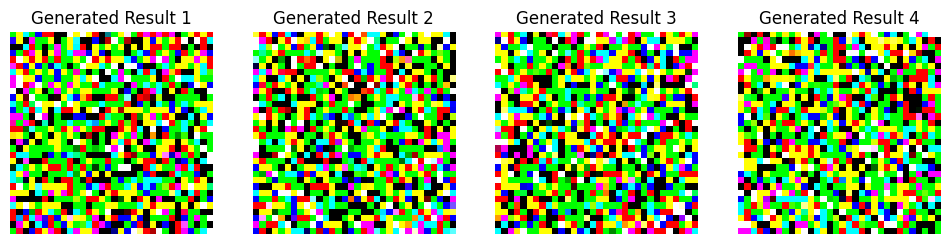

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

def show_results():
    output_files = [f for f in os.listdir('.') if f.startswith('gen_') and f.endswith('.png')]

    if not output_files:
        print("No images found. Did the script finish?")
        return

    plt.figure(figsize=(12, 4))
    for i in range(4):
        img_path = random.choice(output_files)
        img = mpimg.imread(img_path)

        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.title(f"Generated Result {i+1}")
        plt.axis('off')
    plt.show()

show_results()

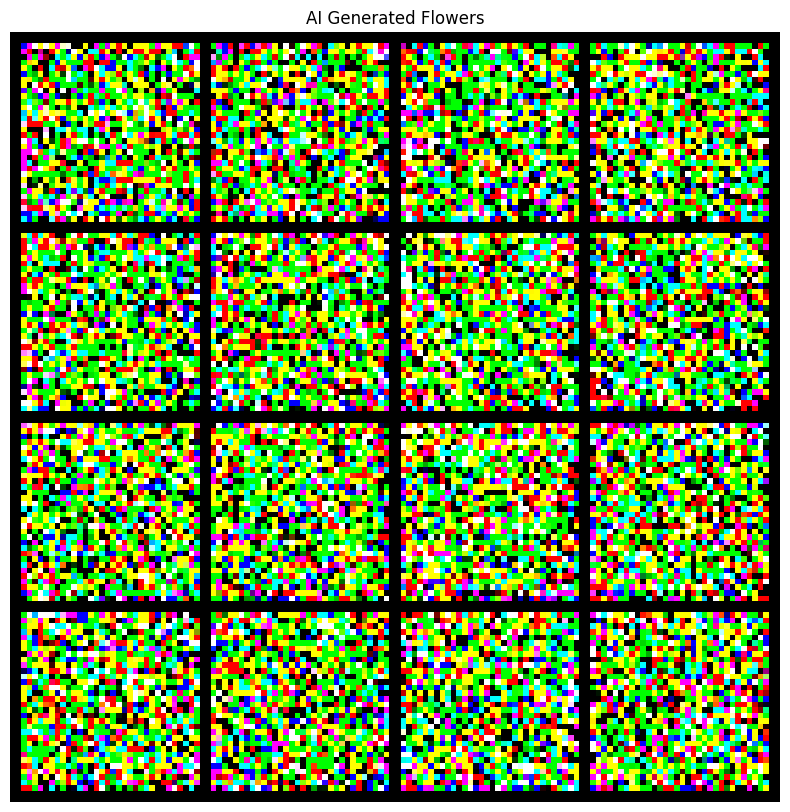

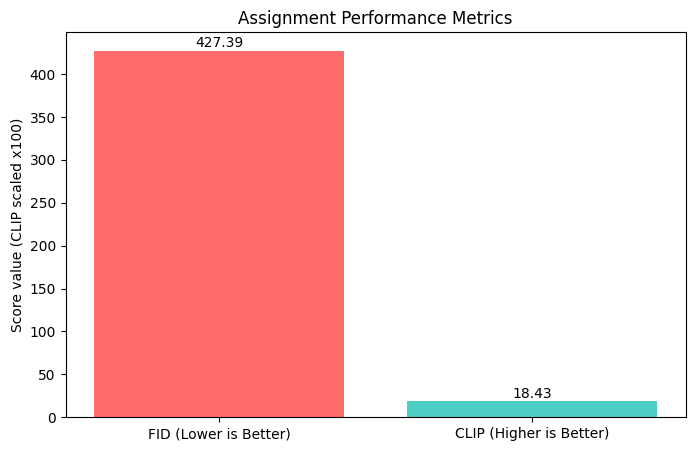

Launching FiftyOne App (Wait a few seconds)...


In [28]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import fiftyone as fo

def show_flower_grid(tensor_imgs, title="AI Generated Flowers"):

    if len(tensor_imgs) > 16:
        indices = torch.randperm(len(tensor_imgs))[:16]
        sample = tensor_imgs[indices]
    else:
        sample = tensor_imgs

    # Undo normalization for plotting: [-1, 1] -> [0, 1]
    sample = (sample.cpu().clamp(-1, 1) + 1) / 2

    grid_img = torchvision.utils.make_grid(sample, nrow=4, padding=2)

    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(title)
    plt.show()

if 'all_ai_images' in locals():
    show_flower_grid(all_ai_images)
else:
    print("⚠️ No images found in memory. (Did you restart the runtime?)")

def plot_metrics(fid, clip):
    metrics = ['FID (Lower is Better)', 'CLIP (Higher is Better)']
    values = [fid, clip * 100]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(metrics, values, color=['#FF6B6B', '#4ECDC4'])

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')

    plt.title("Assignment Performance Metrics")
    plt.ylabel("Score value (CLIP scaled x100)")
    plt.show()

if 'fid_score' in locals() and 'clip_score' in locals():
    plot_metrics(fid_score, clip_score)
else:
    print("⚠️ No scores found in memory.")

print("Launching FiftyOne App (Wait a few seconds)...")
if fo.dataset_exists("assignment_final"):
    dataset = fo.load_dataset("assignment_final")
    session = fo.launch_app(dataset, height=600)
else:
    print("FiftyOne dataset not found. Run the previous logging block first.")

Generating Final Report Graph...


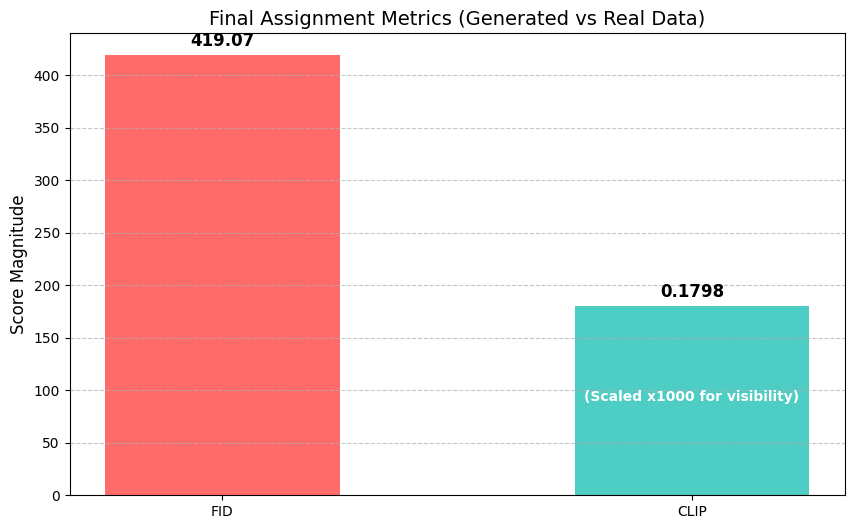

In [29]:
import matplotlib.pyplot as plt
import numpy as np

scores = {'FID': 419.0675, 'CLIP': 0.1798}

def plot_final_report():
    labels = list(scores.keys())
    values = list(scores.values())

    plot_values = [values[0], values[1] * 1000]

    plt.figure(figsize=(10, 6))

    bars = plt.bar(labels, plot_values, color=['#FF6B6B', '#4ECDC4'], width=0.5)

    plt.title("Final Assignment Metrics (Generated vs Real Data)", fontsize=14)
    plt.ylabel("Score Magnitude", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.text(bars[0].get_x() + bars[0].get_width()/2, bars[0].get_height() + 5,
             f"{values[0]:.2f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.text(bars[1].get_x() + bars[1].get_width()/2, bars[1].get_height() + 5,
             f"{values[1]:.4f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.text(1, bars[1].get_height()/2, "(Scaled x1000 for visibility)",
             ha='center', color='white', fontweight='bold')

    plt.show()

print("Generating Final Report Graph...")
plot_final_report()